In [ ]:
import chardet
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from google.colab import files

I am reading the first 10 000 bytes of the cars.csv file, to detect its encoding.

In [ ]:
with open("cars.csv", "rb") as f:
    rawdata = f.read(10000)
    result = chardet.detect(rawdata)
    print(result)

{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


In [ ]:
cars = pd.read_csv("cars.csv", encoding="utf-16")

In [ ]:
cars.shape

(144867, 7)

I decided to limit the data to the last 5 years, for further analysis and reporting in Microsoft Excel.

In [ ]:
cars=cars[cars["Year"].isin([2020,2021,2022,2023,2024])]

In [ ]:
cars.shape

(117617, 7)

Now our dataset contains 117617 records and 7 columns.

In [ ]:
cars.head()

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,36703.0
1,Kia,Sportage,2023,New,NaN,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0


In [ ]:
cars.describe()

,Year,Mileage,Price
count,117617.000000,28688.000000,1.137150e+05
mean,2022.907581,27153.240937,5.868496e+04
std,1.105451,20544.587564,4.180740e+04
min,2020.000000,0.000000,1.000000e+00
25%,2023.000000,10731.750000,3.900000e+04
50%,2023.000000,23513.000000,5.202600e+04
75%,2024.000000,38844.250000,6.964000e+04
max,2024.000000,288019.000000,8.078160e+06


In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117617 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  object 
 1   Model    117617 non-null  object 
 2   Year     117617 non-null  int64  
 3   Status   117617 non-null  object 
 4   Mileage  28688 non-null   float64
 5   Dealer   117289 non-null  object 
 6   Price    113715 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.2+ MB


In [ ]:
cars.isnull().sum()

,0
Brand,0
Model,0
Year,0
Status,0
Mileage,88929
Dealer,328
Price,3902


In [ ]:
mask = cars.isnull() #create a logical mask (true/false)
total = mask.sum()  #the count of missing values in each column
per = 100*mask.mean()  #the percent of missing values in each kolumn

missing_data = pd.concat([total, per], axis=1, keys=['missing value', 'percentage'])
missing_data.sort_values(by='percentage', ascending=False, inplace=True)
missing_data

,missing value,percentage
Mileage,88929,75.608968
Price,3902,3.317548
Dealer,328,0.278871
Year,0,0.000000
Model,0,0.000000
Brand,0,0.000000
Status,0,0.000000


Unfortunately attributes: "Mileage", "Dealer", "Price" have lack of data.

That's why I will fill the missing values ​​(instead of deleting the missing records),

to avoid losing potentially important observations.

# Missing Values Handling

**1. fillna() method** for missing columns, that are numeric:

In [ ]:
upd_fillna = cars.copy(deep=True)
upd1_fillna = cars.copy(deep=True)

In [ ]:
upd_fillna['Price'] = upd_fillna['Price'].fillna(upd_fillna['Price'].mean())
upd1_fillna['Mileage'] = upd1_fillna['Mileage'].fillna(upd1_fillna['Mileage'].mean())

In [ ]:
upd_fillna.isnull().sum()

,0
Brand,0
Model,0
Year,0
Status,0
Mileage,88929
Dealer,328
Price,0


In [ ]:
upd1_fillna.isnull().sum()

,0
Brand,0
Model,0
Year,0
Status,0
Mileage,0
Dealer,328
Price,3902


I will use a histogram to check the distribution of the data before and after filling in the missing values.

First I will have a look at the "Price" column.

In [ ]:
cars['Price'].value_counts().sort_values(ascending=False)

,count
Price,
33000.0,90
60215.0,82
34000.0,72
39995.0,71
29480.0,71
...,...
51713.0,1
84735.0,1
113350.0,1


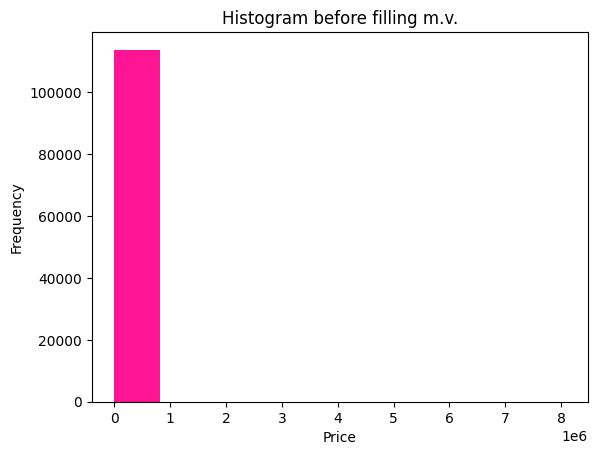

In [ ]:
plt.hist(cars.Price, color = 'deeppink')
plt.title('Histogram before filling m.v.')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

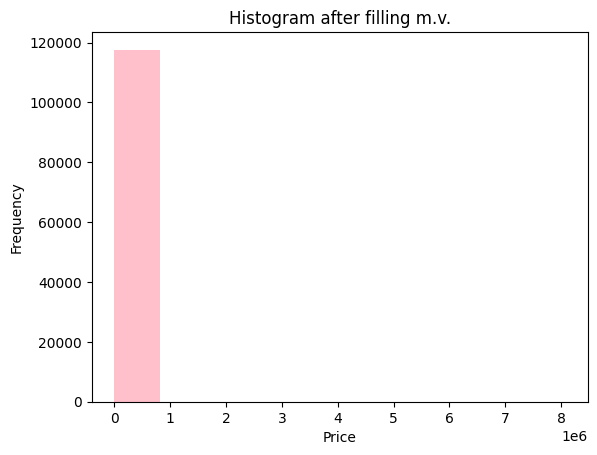

In [ ]:
plt.hist(upd_fillna.Price, color = 'pink')
plt.title('Histogram after filling m.v.')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

For about 3.3% of missing data in column "Price", I filled the missing values with averages,

which does not significantly change the data distribution.

Let's have a look at the "Mileage" column.

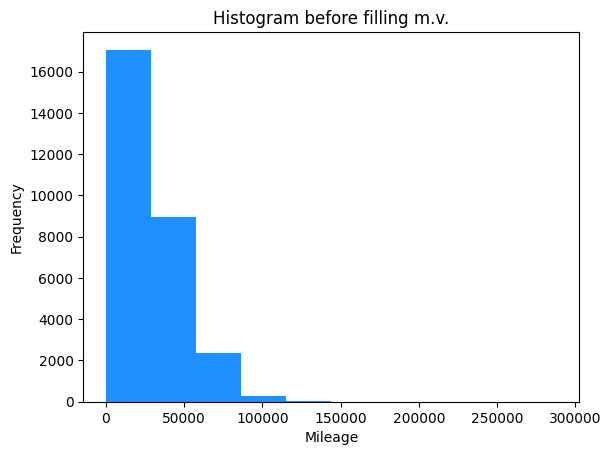

In [ ]:
plt.hist(cars.Mileage, color = 'dodgerblue')
plt.title('Histogram before filling m.v.')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

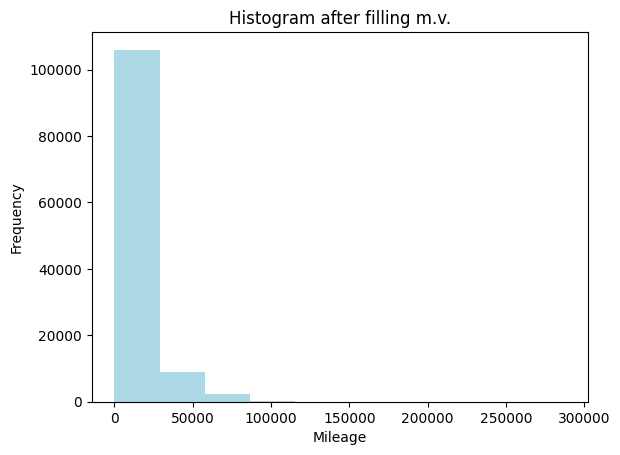

In [ ]:
plt.hist(upd1_fillna.Mileage, color = 'lightblue')
plt.title('Histogram after filling m.v.')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

As we could see earlier, most of the values in the "Mileage" column (about 76%) are missing data.

Therefore, artificially inserting most values in the form of an average into this column may lead to an unrealistic representation of the distribution of values on the histogram.

Most values will be the average of the values in the column.

The consequence of this will be a significant decrease in data variability and its variance.

**2. Simple Imputer method**

For quality column "Dealer" I can also use a class Simple Imputer with the strategy='most_frequent', from module sklearn.imputer, from library Scikit-Learn.

In [ ]:
imputer = SimpleImputer(missing_values=np.nan , strategy='most_frequent') #empty object (no fitted)

In [ ]:
imputer.fit(upd_fillna[["Dealer"]]) #the object fitted with some data

SimpleImputer(strategy='most_frequent')

In [ ]:
upd_fillna[["Dealer"]]=imputer.transform(upd_fillna[["Dealer"]])  #transformation of the column Dealer

In [ ]:
upd_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117617 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  object 
 1   Model    117617 non-null  object 
 2   Year     117617 non-null  int64  
 3   Status   117617 non-null  object 
 4   Mileage  28688 non-null   float64
 5   Dealer   117617 non-null  object 
 6   Price    117617 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.2+ MB


In [ ]:
cars.Dealer.value_counts()

,count
Dealer,
Muller Subaru Volkswagen,178
Knauz Auto Park,172
Tesla,146
Ourisman Lexus,144
Audi McKinney,142
...,...
Ball Auto Group,1
Hyundai of 110,1
Healey Brothers Ford,1


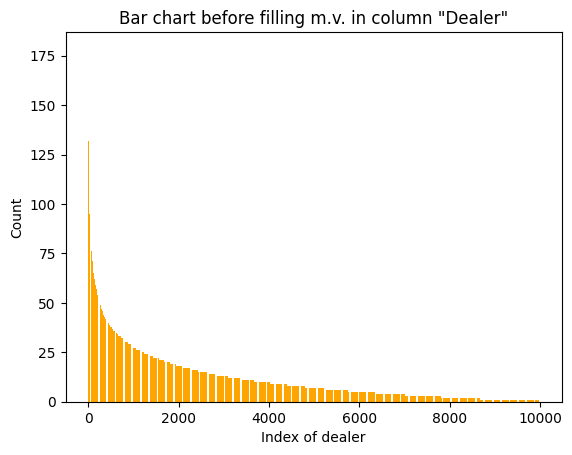

In [ ]:
counts = cars['Dealer'].value_counts()

plt.bar(range(1, len(counts)+1), counts.values, color='orange') #label 1,2,..,len(counts)+1 instead of column names (faster way to display the chart)
plt.xlabel('Index of dealer')
plt.ylabel('Count')
plt.title('Bar chart before filling m.v. in column "Dealer"')
plt.show()


In [ ]:
upd_fillna.Dealer.value_counts()

,count
Dealer,
Muller Subaru Volkswagen,506
Knauz Auto Park,172
Tesla,146
Ourisman Lexus,144
Audi McKinney,142
...,...
South County Buick Gmc,1
"Tim's Truck Capital & Auto Sales, Inc.",1
Jack Madden Ford,1


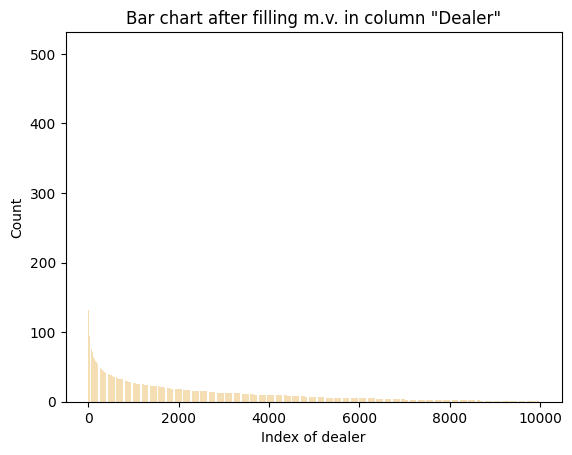

In [ ]:
counts1 = upd_fillna['Dealer'].value_counts()

plt.bar(range(1, len(counts1)+1), counts1.values, color='wheat') #label 1,2,..,len(counts)+1 instead of column names (faster way to display the chart)
plt.xlabel('Index of dealer')
plt.ylabel('Count')
plt.title('Bar chart after filling m.v. in column "Dealer"')
plt.show()

The charts contains a very large number of categories, which makes the distribution highly skewed.

First cathegories clearly dominates in terms of the number of occurrences (especially after assigning the missing values to the most frequently occurring category), while the others appear sporadically, which makes the charts hard to read.

**3. KNN Imputer method**

Now I will try to use the method KNN Imputer (K-Nearest Neighbours Imputation) on the "Mileage" atribute <== Machine Learning Method.

KNN Imputer fills the lack od data, by using values from the nearest data points (neighbors) in the dataset.

KNN for a single column is cost-ineffective, as we want the values to be predicted based on similarities between rows.

99% of scikit-learn functions cannot handle qualitative values, so we need to encode these labels before starting to train the model.

**Label Encoding** is the method from the scikit-learn library, which transform qualitative values into quantitative labels.

In [ ]:
upd_fillna

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,Muller Subaru Volkswagen,36703.0
1,Kia,Sportage,2023,New,NaN,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0
...,...,...,...,...,...,...,...
144862,Chevrolet,Corvette,2023,New,NaN,Chase Chevrolet,122455.0
144863,Chevrolet,Corvette,2023,New,NaN,Chase Chevrolet,125930.0
144864,Jeep,Wrangler,2023,New,NaN,Stockton Dodge Chrysler Jeep RAM,53715.0
144865,Jeep,Wrangler,2023,New,NaN,Stockton Dodge Chrysler Jeep RAM,91450.0


In [ ]:
df_encoded = upd_fillna.copy(deep=True)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117617 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  object 
 1   Model    117617 non-null  object 
 2   Year     117617 non-null  int64  
 3   Status   117617 non-null  object 
 4   Mileage  28688 non-null   float64
 5   Dealer   117617 non-null  object 
 6   Price    117617 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.2+ MB


In [ ]:
cols_object = df_encoded.select_dtypes(include='object').columns
encoders={}

In [ ]:
for col in cols_object:
  le=LabelEncoder()
  df_encoded[col] = le.fit_transform(df_encoded[col])
  encoders[col]=le
df_encoded

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,31,75,2023,1,NaN,6635,36703.0
1,22,317,2023,1,NaN,2053,28990.0
2,8,77,2024,1,NaN,2033,41425.0
3,13,62,2023,2,1551.0,6438,58900.0
4,0,324,2021,2,30384.0,6440,34499.0
...,...,...,...,...,...,...,...
144862,8,94,2023,1,NaN,1912,122455.0
144863,8,94,2023,1,NaN,1912,125930.0
144864,20,353,2023,1,NaN,8673,53715.0
144865,20,353,2023,1,NaN,8673,91450.0


In [ ]:
encoders

{'Brand': LabelEncoder(),
 'Model': LabelEncoder(),
 'Status': LabelEncoder(),
 'Dealer': LabelEncoder()}

In [ ]:
df_encoded.shape

(117617, 7)

In [ ]:
#Instead of float64, I use float32 = less RAM + faster calculations
df_encoded = df_encoded.astype(np.float32)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117617 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  float32
 1   Model    117617 non-null  float32
 2   Year     117617 non-null  float32
 3   Status   117617 non-null  float32
 4   Mileage  28688 non-null   float32
 5   Dealer   117617 non-null  float32
 6   Price    117617 non-null  float32
dtypes: float32(7)
memory usage: 4.0 MB


**KNN Imputer**

In [ ]:
imputer_knn = KNNImputer(n_neighbors=2) #create an object of the class KNNImputer
imputed_array = imputer_knn.fit_transform(df_encoded)  #fit and transform (average of the neighbours values)
imputed_array

array([[3.10000e+01, 7.50000e+01, 2.02300e+03, ..., 2.55425e+04,
        6.63500e+03, 3.67030e+04],
       [2.20000e+01, 3.17000e+02, 2.02300e+03, ..., 2.22915e+04,
        2.05300e+03, 2.89900e+04],
       [8.00000e+00, 7.70000e+01, 2.02400e+03, ..., 6.14750e+03,
        2.03300e+03, 4.14250e+04],
       ...,
       [2.00000e+01, 3.53000e+02, 2.02300e+03, ..., 3.14655e+04,
        8.67300e+03, 5.37150e+04],
       [2.00000e+01, 3.53000e+02, 2.02300e+03, ..., 1.99990e+04,
        8.67300e+03, 9.14500e+04],
       [9.00000e+00, 5.00000e+00, 2.02300e+03, ..., 4.17700e+03,
        8.67300e+03, 5.20000e+04]], dtype=float32)

In [ ]:
#Create imputed DataFrame
df_imputed = pd.DataFrame(imputed_array, columns=df_encoded.columns) #because of transformation we have lost data frame and now we have []. we need to rebuild df
df_imputed

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,31.0,75.0,2023.0,1.0,25542.5,6635.0,36703.0
1,22.0,317.0,2023.0,1.0,22291.5,2053.0,28990.0
2,8.0,77.0,2024.0,1.0,6147.5,2033.0,41425.0
3,13.0,62.0,2023.0,2.0,1551.0,6438.0,58900.0
4,0.0,324.0,2021.0,2.0,30384.0,6440.0,34499.0
...,...,...,...,...,...,...,...
117612,8.0,94.0,2023.0,1.0,33350.0,1912.0,122455.0
117613,8.0,94.0,2023.0,1.0,7010.5,1912.0,125930.0
117614,20.0,353.0,2023.0,1.0,31465.5,8673.0,53715.0
117615,20.0,353.0,2023.0,1.0,19999.0,8673.0,91450.0


In [ ]:
for col in cols_object:
  df_imputed[col] = df_imputed[col].round().astype(int)  #round to integer gualitative cols
df_imputed

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,31,75,2023.0,1,25542.5,6635,36703.0
1,22,317,2023.0,1,22291.5,2053,28990.0
2,8,77,2024.0,1,6147.5,2033,41425.0
3,13,62,2023.0,2,1551.0,6438,58900.0
4,0,324,2021.0,2,30384.0,6440,34499.0
...,...,...,...,...,...,...,...
117612,8,94,2023.0,1,33350.0,1912,122455.0
117613,8,94,2023.0,1,7010.5,1912,125930.0
117614,20,353,2023.0,1,31465.5,8673,53715.0
117615,20,353,2023.0,1,19999.0,8673,91450.0


In [ ]:
#Decode qualitative columns back to text
for col in cols_object:
  le=encoders[col]
  df_imputed[col] = le.inverse_transform(df_imputed[col])
df_imputed

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023.0,New,25542.5,Muller Subaru Volkswagen,36703.0
1,Kia,Sportage,2023.0,New,22291.5,Classic Kia,28990.0
2,Chevrolet,Camaro,2024.0,New,6147.5,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023.0,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021.0,Used,30384.0,Mike Smith Nissan,34499.0
...,...,...,...,...,...,...,...
117612,Chevrolet,Corvette,2023.0,New,33350.0,Chase Chevrolet,122455.0
117613,Chevrolet,Corvette,2023.0,New,7010.5,Chase Chevrolet,125930.0
117614,Jeep,Wrangler,2023.0,New,31465.5,Stockton Dodge Chrysler Jeep RAM,53715.0
117615,Jeep,Wrangler,2023.0,New,19999.0,Stockton Dodge Chrysler Jeep RAM,91450.0


In [ ]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117617 entries, 0 to 117616
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  object 
 1   Model    117617 non-null  object 
 2   Year     117617 non-null  float32
 3   Status   117617 non-null  object 
 4   Mileage  117617 non-null  float32
 5   Dealer   117617 non-null  object 
 6   Price    117617 non-null  float32
dtypes: float32(3), object(4)
memory usage: 4.9+ MB


In [ ]:
df_imputed['Year']=df_imputed['Year'].astype(int)

In [ ]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117617 entries, 0 to 117616
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    117617 non-null  object 
 1   Model    117617 non-null  object 
 2   Year     117617 non-null  int64  
 3   Status   117617 non-null  object 
 4   Mileage  117617 non-null  float32
 5   Dealer   117617 non-null  object 
 6   Price    117617 non-null  float32
dtypes: float32(2), int64(1), object(4)
memory usage: 5.4+ MB


Savind cleaned data frame to csv file and later download it.

In [ ]:
df_imputed.to_csv('cleaned_cars.csv', index=False)

In [61]:
files.download('cleaned_cars.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>